In [1]:
import os
os.chdir("../")

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import catboost as cb
from scr.util import *

In [22]:
# データセットを整形

pass_train = 'data/feature_engineered/train_feature_ok.csv'
pass_test = 'data/feature_engineered/test_feature_ok.csv'

df = pd.read_csv(pass_train)
df_submit = pd.read_csv(pass_test)


# 特徴量選択
feature = [
    'Age',
    'TypeofContact',
    'CityTier',
    'DurationOfPitch',
    'Occupation',
    'Gender',
    'NumberOfPersonVisiting',
    'NumberOfFollowups',
    'ProductPitched',
    'PreferredPropertyStar',
    'NumberOfTrips',
    'Passport',
    'PitchSatisfactionScore',
    'Designation',
    'MonthlyIncome',
    'Marry',
    'Car',
    'Child',
    # 以下、作成特徴量
    'AgeGroup',
    'TypeofContactNULL',
    'Motivation',
    'EconomicPower',
    'Child01',
    'TripEasier',
    'SalesPerformance',
    'LivingCost',
    'EconomicStability'
]

# 型選択
float_columns = ['DurationOfPitch', 'MonthlyIncome'] + ['EconomicPower']
int_columns = ['Age', 'NumberOfTrips', 'TypeofContact', 'CityTier', 'Occupation', 
                'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched', 
                'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore', 'Designation',
                'Marry', 'Car', 'Child'] + ['AgeGroup', 'TypeofContactNULL', 'Motivation', 'TripEasier', 'SalesPerformance', 'LivingCost', 'EconomicStability']
# catboostで措定
category_columns = ['TypeofContact', 'CityTier', 'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched', 
                'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore', 'Designation', 'Marry', 'Car'] # Child


df = mapping_columns_if_exist(df)
df_submit = mapping_columns_if_exist(df_submit)
df, df_submit = convert_type(df, df_submit, float_columns=float_columns, int_columns=int_columns)


X = df[feature]
y = df['ProdTaken']
df_submit = df_submit[feature]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [23]:
# 学習モデル

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_list = list(skf.split(X, y))

def train_catboost(X, y, cv, params: dict = None):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ))
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
        model = cb.CatBoostRegressor(**params)
        model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
        oof_pred[va_idx] = model.predict(va_x)
        models.append(model)
    return oof_pred, models

params = {
    'loss_function': 'RMSE',
    'eval_metric': 'AUC',
    'iterations': 8000,
    'learning_rate': 0.005,
    'depth': 5,
    # 'cat_features': category_columns,
    'l2_leaf_reg': 7,    # 3 ~ 10
    'verbose': 200,
    'random_seed': 42,
}

oof, models = train_catboost(X, y, cv_list, params)

0:	test: 0.7715050	best: 0.7715050 (0)	total: 1.54ms	remaining: 12.3s
100:	test: 0.8268562	best: 0.8279766 (92)	total: 131ms	remaining: 10.2s
200:	test: 0.8305351	best: 0.8305351 (200)	total: 263ms	remaining: 10.2s
300:	test: 0.8335117	best: 0.8342308 (295)	total: 388ms	remaining: 9.91s
400:	test: 0.8360033	best: 0.8360033 (400)	total: 524ms	remaining: 9.92s
500:	test: 0.8371572	best: 0.8376756 (480)	total: 668ms	remaining: 10s
600:	test: 0.8384950	best: 0.8385117 (599)	total: 863ms	remaining: 10.6s
700:	test: 0.8400836	best: 0.8401003 (699)	total: 1.01s	remaining: 10.5s
800:	test: 0.8411706	best: 0.8411706 (796)	total: 1.15s	remaining: 10.4s
900:	test: 0.8416388	best: 0.8419565 (890)	total: 1.29s	remaining: 10.2s
1000:	test: 0.8418896	best: 0.8420401 (985)	total: 1.43s	remaining: 10s
1100:	test: 0.8421906	best: 0.8422742 (1083)	total: 1.57s	remaining: 9.87s
1200:	test: 0.8423579	best: 0.8423913 (1195)	total: 1.72s	remaining: 9.75s
1300:	test: 0.8428428	best: 0.8430936 (1267)	total: 1.

In [24]:
# モデルを保存

for i, model in enumerate(models):
    with open ('model/catboost/catboost_model_{}.pkl'.format(i), 'wb') as f:
        pickle.dump(model, f)

     feature_importance             column  fold
0              5.694264                Age     1
1              1.550825      TypeofContact     1
2              1.847148           CityTier     1
3              2.617494    DurationOfPitch     1
4              2.137480         Occupation     1
..                  ...                ...   ...
130            0.529516            Child01     5
131           12.696958         TripEasier     5
132            1.146200   SalesPerformance     5
133            1.979379         LivingCost     5
134            2.240412  EconomicStability     5

[135 rows x 3 columns]


C:\Users\ricke\AppData\Local\Temp\ipykernel_14028\4245149276.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_importance_df,


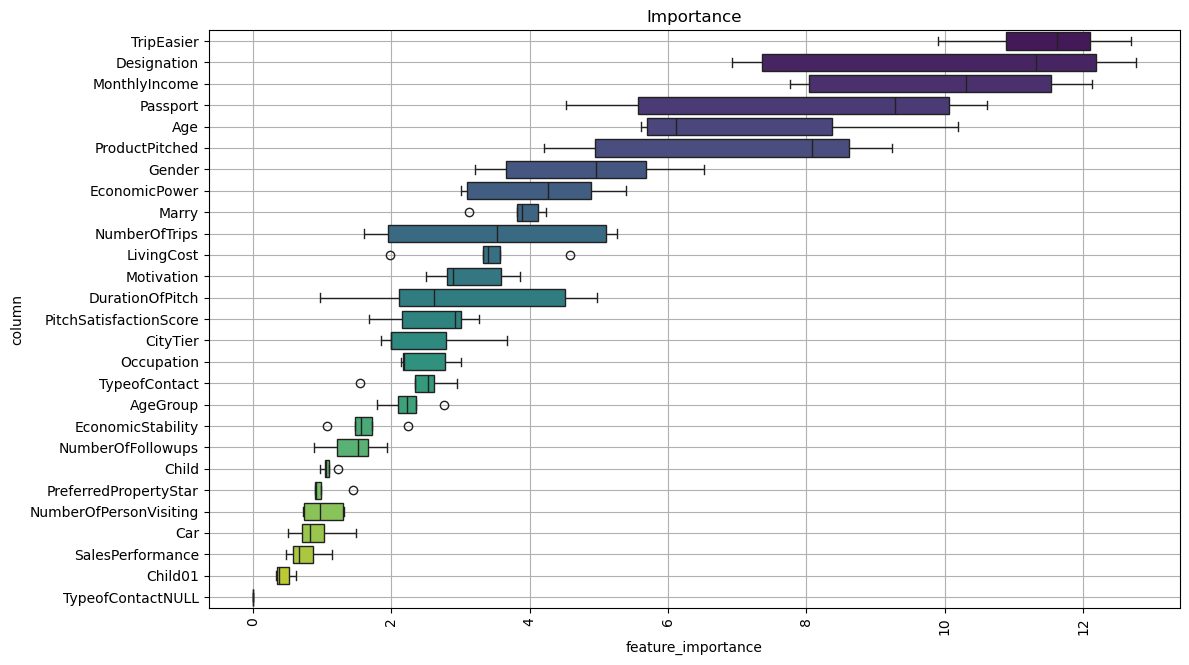

In [25]:
# 特徴量の重要度

def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                        axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    print(feature_importance_df)
    #feature_importance_df_drop_speed = feature_importance_df[feature_importance_df["column"] != "speed"]
    sns.boxplot(data=feature_importance_df,
                x="feature_importance",
                y="column",
                order=order,
                ax=ax,
                palette="viridis",
                orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

fig, ax, feature_importance_df = visualize_importance(models, X)

# 提出

In [16]:
# for col in category_columns:
#     df_submit[col] = df_submit[col].astype('str')

y_submit = np.zeros(len(df_submit))
for model in models:
    y_submit += model.predict(df_submit) / len(models)

index = pd.read_csv('data/test.csv')['id'].values
df_submit = pd.DataFrame({
    "id": index,
    "prediction": y_submit
})

df_submit['prediction'] = np.where(df_submit['prediction'] < 0, 0, df_submit['prediction'])
df_submit.head()

,id,prediction
0,3489,0.059233
1,3490,0.229753
2,3491,0.294823
3,3492,0.446349
4,3493,0.391086


In [20]:
path = 'submission/submit_17_cat_featureselection.csv'

In [21]:
df_submit.to_csv(path, index=False, header=None)